In [1]:
import numpy as np
import torch
from torch import nn, optim

import gymnasium as gym
from gymnasium.wrappers import TimeLimit
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
### GPU health check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Task 1

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, 128)
        self.hidden1 = nn.Linear(128, 128)
        self.norm1 = nn.BatchNorm1d(128)
        # self.hidden2 = nn.Linear(128, 64)
        # self.norm2 = nn.BatchNorm1d(64)
        self.relu = nn.LeakyReLU()
        self.output_layer = nn.Linear(128 ,output_size)
        
        
    def forward(self, x):
        y = self.relu(self.input_layer(x))
        y = self.relu(self.norm1(self.hidden1(y)))
        # y = self.relu(self.norm2(self.hidden2(y)))
        y = self.output_layer(y)
        return y        

In [4]:
net = MLP(4, 5)
x = torch.rand((1, 4))
net.eval()
with torch.no_grad():
    print(net(x))

tensor([[-0.0471, -0.0878,  0.0311,  0.1508, -0.1003]])


### Task 2

In [5]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

target = torch.tensor([[1, 0, 0, 1, 0]], dtype=torch.float32)

print("sample weight before backprop:", net.input_layer.weight[0,:])
optimizer.zero_grad()
net.eval()
y = net(x)
loss = loss_fn(y, target)
loss.backward()
optimizer.step()
print("sample weight after backprop:", net.input_layer.weight[0,:])
print("loss:", loss.item())

sample weight before backprop: tensor([ 0.1968, -0.0590, -0.0095, -0.1206], grad_fn=<SliceBackward0>)
sample weight after backprop: tensor([ 0.1967, -0.0591, -0.0096, -0.1207], grad_fn=<SliceBackward0>)
loss: 0.3672661781311035


### Task 3

In [6]:
torch.manual_seed(42)
input_data = torch.rand((16, 4)).to(device)
target = torch.rand((16, 5)).to(device)

print("sample training dataset")
print(input_data[0, :])
print(target[0, :])
print()

net = MLP(4, 5).to(device)
loss_fn = nn.SmoothL1Loss()
optimizer = optim.Adam(net.parameters(), lr=5e-4)

print("start traning")
for epoch in range(100):
    
    optimizer.zero_grad()
    
    output = net(input_data)
    
    loss = loss_fn(target, output)
    
    loss.backward()
    optimizer.step()
    
    if epoch%20 == 0:
        print("loss:", loss.item())

sample training dataset
tensor([0.8823, 0.9150, 0.3829, 0.9593], device='cuda:0')
tensor([0.6532, 0.3958, 0.9147, 0.2036, 0.2018], device='cuda:0')

start traning
loss: 0.23281697928905487
loss: 0.014884429052472115
loss: 0.00415765168145299
loss: 0.000993550755083561
loss: 0.00031444421620108187


In [7]:
net.eval()
print("evaluate model")
print("output:", net(input_data[5].unsqueeze(0)))
print("target:", target[5])

evaluate model
output: tensor([[0.6346, 0.6141, 0.3683, 0.7842, 0.8022]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
target: tensor([0.6524, 0.6057, 0.3725, 0.7980, 0.8399], device='cuda:0')


### Task 4

In [8]:
class TimeLimitWrapper(gym.Wrapper):
    def __init__(self, env, max_steps):
        super(TimeLimitWrapper, self).__init__(env)
        self.max_steps = max_steps
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self.env.reset()

    def step(self, action):
        next_state, reward, done, _, _ = self.env.step(action)
        self.current_step += 1
        if self.current_step >= int(self.max_steps*0.8) and reward > 150:
            done = True
        if self.current_step >= self.max_steps:
            reward = reward - 150 # Timeout penalty
            done = True
        return next_state, reward, done, _, _

In [9]:
# Initialize the environment
env = gym.make("LunarLander-v2")
env = TimeLimitWrapper(env, max_steps=500)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(state_size, action_size)

# Hyperparameters
EPISODES = 500
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
MEMORY_SIZE = 10000
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

8 4


In [10]:
# Initialize the DQN
policy_net = MLP(state_size, action_size).to(device)
target_net = MLP(state_size, action_size).to(device)
best_net = MLP(state_size, action_size).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = deque(maxlen=MEMORY_SIZE)

epsilon = EPSILON_START

/tmp/ipykernel_259207/4061353365.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  states = torch.tensor(states, dtype=torch.float32).to(device)


Episode: 0, Reward: -374.73907362301924, Epsilon: 0.99, loss: 0.31867432594299316
Episode: 10, Reward: -228.52472312851685, Epsilon: 0.95, loss: 8.04583740234375
Episode: 20, Reward: -84.86805689182046, Epsilon: 0.90, loss: 1.4556993246078491
Episode: 30, Reward: -214.1837552894014, Epsilon: 0.86, loss: 32.47742462158203
Episode: 40, Reward: -420.7202029982104, Epsilon: 0.81, loss: 4.674350738525391
Episode: 50, Reward: -68.93828210566463, Epsilon: 0.77, loss: 40.18852615356445
Episode: 60, Reward: -101.44432667304974, Epsilon: 0.74, loss: 17.839439392089844
Episode: 70, Reward: -76.17957330522509, Epsilon: 0.70, loss: 1.351485013961792
Episode: 80, Reward: -102.61922707069488, Epsilon: 0.67, loss: 32.6277961730957
Episode: 90, Reward: -113.83552927204576, Epsilon: 0.63, loss: 36.12750244140625
Episode: 100, Reward: -59.511355667843134, Epsilon: 0.60, loss: 4.4275007247924805
Episode: 110, Reward: -256.9130141848681, Epsilon: 0.57, loss: 3.3594565391540527
Episode: 120, Reward: -77.616

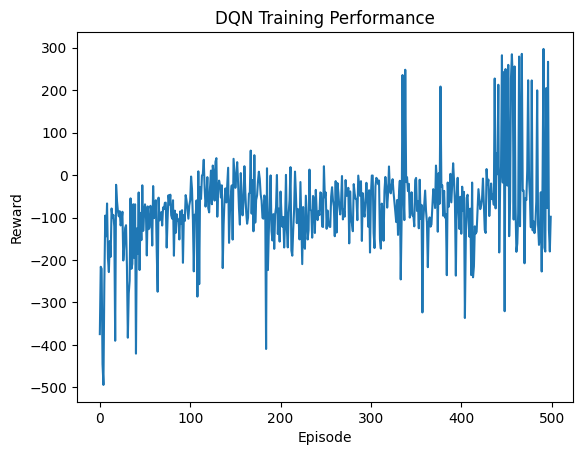

In [11]:
def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return random.randrange(action_size)
    else:
        with torch.no_grad():
            policy_net.eval()
            return policy_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()

def replay():
    if len(memory) < BATCH_SIZE:
        return
    minibatch = random.sample(memory, BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = torch.tensor(states, dtype=torch.float32).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

    current_q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

def update_target_net():
    target_net.load_state_dict(policy_net.state_dict())

# Training loop
rewards = []
mx_reward = -1e9
for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    policy_net.train()
    
    while not done:
        action = select_action(state, policy_net, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        
        loss = replay()
    
    rewards.append(total_reward)
    if total_reward > mx_reward:
            mx_reward = total_reward
            best_net.load_state_dict(policy_net.state_dict())
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    if episode % 10 == 0:
        update_target_net()
        print(f"Episode: {episode}, Reward: {total_reward}, Epsilon: {epsilon:.2f}, loss: {loss}")

# Plotting rewards
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN Training Performance')
plt.show()

In [14]:
# Re-initialize the environment for visualization
env = gym.make("LunarLander-v2", render_mode="human")
env = TimeLimitWrapper(env, max_steps=800)

# Function to play the environment
def play_environment(env, policy_net, episodes=5):
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            env.render()
            action = select_action(state, policy_net, 0.0)  # Select action with epsilon=0 (greedy)
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
        print(f"Episode: {episode+1}, Total Reward: {total_reward}")

# Play the environment after training
play_environment(env, best_net)

# Close the environment
env.close()

Episode: 1, Total Reward: 212.31410360400838
Episode: 2, Total Reward: -93.51377778047555
Episode: 3, Total Reward: -91.24535030130515
Episode: 4, Total Reward: 175.41286860473042
Episode: 5, Total Reward: 173.29282933593075


In [13]:
env.close()